# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, MinMaxScaler,RobustScaler,MaxAbsScaler
from sklearn.compose import ColumnTransformer
from  sklearn.pipeline  import  Pipeline
from  sklearn  import  set_config
set_config(display='diagram')

In [3]:
from sklearn.neural_network import MLPRegressor

# Custom functions

In [4]:
def dataset_parameters(df,target):
    df_features = df.drop([target], axis=1)
    data_type_numerical = ['int64', 'float64']
    data_type_object = ['object', 'bool', 'category']
    data_type_date = ['datetime64']
    categorical_features  = list(filter(lambda x: df_features[x].dtype in data_type_object, df_features.columns))
    numerical_features = list(filter(lambda x: df_features[x].dtype in data_type_numerical, df_features.columns))
    date_features = list(filter(lambda x: df_features[x].dtype in data_type_date, df_features.columns))
    all_features  = numerical_features  + categorical_features + date_features 
    return categorical_features, numerical_features, date_features, all_features,target 

In [5]:
def regrerssion_performance(model, X, y):
    y_pred = model.predict(X)
    r2 = round(r2_score(y, y_pred),3)
    mse = round(mean_squared_error(y, y_pred))
    mae = round(mean_absolute_error(y, y_pred))
    return pd.DataFrame({'pipeline':[str(model)], 'R2':[r2], 'mean_absolute_error':[mae], 'mean_square_error':[mse]})

In [6]:
def regression_analysis(df):
    df['pipeline'] = df['pipeline'].apply(lambda x: x.split('(')[0])
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    sns.barplot( x ='pipeline', y='R2', data=df, ax=axs[0])
    axs[0].set_ylim(0, 1)
    axs[0].set_xlabel('')
    axs[0].set_ylabel('R2', fontsize=18)
    plt.setp(axs[0].get_xticklabels(), rotation=60, fontsize=13)
    plt.setp(axs[0].get_yticklabels(), fontsize=8)
    axs[0].grid(axis='y', linestyle='--', linewidth=0.8)

    sns.barplot( x ='pipeline', y='mean_absolute_error', data=df, ax=axs[1])
    axs[1].set_xlabel('')
    axs[1].set_ylabel('MAE', fontsize=18)
    plt.setp(axs[1].get_xticklabels(), rotation=60, fontsize=13)
    plt.setp(axs[1].get_yticklabels(), fontsize=8)
    axs[1].grid(axis='y', linestyle='--', linewidth=0.8)

    sns.barplot( x ='pipeline', y='mean_square_error', data=df, ax=axs[2])
    axs[2].set_xlabel('')
    axs[2].set_ylabel('MQE', fontsize=18)
    plt.setp(axs[2].get_xticklabels(), rotation=60, fontsize=13)
    plt.setp(axs[2].get_yticklabels(), fontsize=8)
    axs[2].grid(axis='y', linestyle='--', linewidth=0.8)

    plt.show()
    return df

# Loading and set data

In [7]:
with open('diamonds_df.pkl', 'rb') as f:
    df = pickle.load(f)

In [8]:
df

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326.0
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326.0
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327.0
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334.0
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335.0
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,5.75,5.76,3.50,2757.0
53936,0.72,Good,D,SI1,63.1,55.0,5.69,5.75,3.61,2757.0
53937,0.70,Very Good,D,SI1,62.8,60.0,5.66,5.68,3.56,2757.0
53938,0.86,Premium,H,SI2,61.0,58.0,6.15,6.12,3.74,2757.0


In [9]:
categorical_features, numerical_features, date_features, all_features, target = dataset_parameters(df,'price')

In [10]:
X = df[all_features]

In [11]:
y = df[target]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13) 

# Setup pipeline

In [13]:
categorical_transformer = Pipeline(steps=[
    ('one' , OneHotEncoder())
])

In [14]:
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('normalize', Normalizer())
])

In [15]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

In [16]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', MLPRegressor())
])

In [17]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler()),
                                                                  ('normalize',
                                                                   Normalizer())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder())]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('model', MLPRegressor())])

# Setup and run grid search

In [18]:
params_space = {
    'preprocessor__num__scale': [StandardScaler(), MaxAbsScaler(), MinMaxScaler(), RobustScaler()],
    'preprocessor__num__normalize': [Normalizer(), 'passthrough'],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__hidden_layer_sizes' : [(50, 20, 50), (50, 50, 50), (10, 20, 10)],
    'model__max_iter': [200, 400, 600],
    'model__power_t': [0.25, 0.5]
}

In [19]:
scoring = {
    'neg_mean_squared_error': 'neg_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'r2': 'r2'
}

In [20]:
grid = GridSearchCV(pipeline, param_grid=params_space, cv=10, n_jobs=-1, scoring=scoring, refit='r2', verbose=2)

In [ ]:
grid.fit(X_train,  y_train)

In [22]:
grid.best_score_

0.9801164362938328

In [23]:
grid.best_params_

{'model__alpha': 0.01,
 'model__hidden_layer_sizes': (50, 50, 50),
 'model__learning_rate_init': 0.001,
 'model__max_iter': 600,
 'model__power_t': 0.5,
 'preprocessor__num__normalize': Normalizer(),
 'preprocessor__num__scale': MinMaxScaler()}

In [24]:
grid.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('normalize',
                                                                   Normalizer())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder())]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('model',
                 MLPRegressor(alpha=0.01, hidden_layer_sizes=(50, 50, 50),
                              max_iter=600))])

In [27]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_r2', ascending=True).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__hidden_layer_sizes,param_model__learning_rate_init,param_model__max_iter,param_model__power_t,param_preprocessor__num__normalize,...,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,mean_test_r2,std_test_r2,rank_test_r2
1050,199.650342,89.426732,0.095451,0.011728,0.01,"(50, 50, 50)",0.001,600,0.5,Normalizer(),...,0.980814,0.981060,0.982815,0.979952,0.979620,0.979961,0.978616,0.980116,0.001282,1
1026,169.276567,39.482822,0.090109,0.012910,0.01,"(50, 50, 50)",0.001,400,0.25,Normalizer(),...,0.980346,0.981331,0.982865,0.979867,0.979387,0.979972,0.977655,0.980045,0.001466,2
1033,237.353542,86.093808,0.096804,0.016533,0.01,"(50, 50, 50)",0.001,400,0.5,Normalizer(),...,0.980695,0.979535,0.983079,0.977422,0.980238,0.979813,0.980083,0.979891,0.001409,3
578,103.387872,24.801241,0.064813,0.017726,0.001,"(50, 50, 50)",0.001,200,0.25,Normalizer(),...,0.980516,0.980883,0.981862,0.980028,0.979431,0.979856,0.977730,0.979794,0.001269,4
169,188.768767,35.270320,0.083561,0.008712,0.0001,"(50, 50, 50)",0.001,400,0.5,Normalizer(),...,0.980242,0.980982,0.982462,0.977528,0.979918,0.979364,0.979023,0.979712,0.001337,5
170,158.647897,47.530659,0.066633,0.012018,0.0001,"(50, 50, 50)",0.001,400,0.5,Normalizer(),...,0.980386,0.978666,0.983016,0.980412,0.979555,0.979976,0.978220,0.979689,0.001486,6
594,203.978559,89.960925,0.082648,0.017908,0.001,"(50, 50, 50)",0.001,400,0.25,Normalizer(),...,0.980356,0.979460,0.983134,0.978103,0.979427,0.980084,0.976921,0.979681,0.001666,7
458,138.868793,49.286062,0.052397,0.008528,0.001,"(50, 20, 50)",0.001,400,0.5,Normalizer(),...,0.980897,0.980528,0.980909,0.979721,0.979605,0.980492,0.976262,0.979617,0.001412,8
1025,191.746536,60.087743,0.098144,0.015896,0.01,"(50, 50, 50)",0.001,400,0.25,Normalizer(),...,0.979901,0.980673,0.982531,0.976186,0.978901,0.980137,0.979926,0.979614,0.001562,9
1049,202.593207,43.282220,0.092787,0.010962,0.01,"(50, 50, 50)",0.001,600,0.5,Normalizer(),...,0.981007,0.980456,0.982061,0.976034,0.978299,0.979584,0.979879,0.979583,0.001685,10


# Base vs Best pipeline

In [28]:
categorical_transformer_base = Pipeline(steps=[
    ('one' , OneHotEncoder()),
    ('normalize', Normalizer())
])

In [29]:
numerical_transformer_base = Pipeline(steps=[
    ('scale', StandardScaler()),
])

In [30]:
preprocessor_base = ColumnTransformer(transformers=[
    ('num', numerical_transformer_base, numerical_features),
    ('cat', categorical_transformer_base, categorical_features)
])

In [31]:
pipeline_base = Pipeline(steps=[
    ('preprocessor', preprocessor_base),
    ('model', MLPRegressor())
])

In [32]:
pipeline_base.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder()),
                                                                  ('normalize',
                                                                   Normalizer())]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('model', MLPRegressor())])

In [33]:
categorical_transformer_best = Pipeline(steps=[
    ('one' , OneHotEncoder())
])

In [34]:
numerical_transformer_best = Pipeline(steps=[
    ('scale', MinMaxScaler()),
    ('normalize', Normalizer())
])

In [35]:
preprocessor_best = ColumnTransformer(transformers=[
    ('num', numerical_transformer_best, numerical_features),
    ('cat', categorical_transformer_best, categorical_features)
])

In [36]:
pipeline_best = Pipeline(steps=[
    ('preprocessor', preprocessor_best),
    ('model', MLPRegressor(alpha=0.01, hidden_layer_sizes=(50, 50, 50), max_iter=600))
])

In [37]:
pipeline_best.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler()),
                                                                  ('normalize',
                                                                   Normalizer())]),
                                                  ['carat', 'depth', 'table',
                                                   'x', 'y', 'z']),
                                                 ('cat',
                                                  Pipeline(steps=[('one',
                                                                   OneHotEncoder())]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('model',
                 MLPRegressor(alpha=0.01, hidden_layer_sizes=(50, 50, 50),
                              max_iter=600))])

In [38]:
pipeline_base_train = regrerssion_performance(pipeline_base, X_train, y_train)
pipeline_base_test = regrerssion_performance(pipeline_base, X_test, y_test)

In [39]:
pipeline_base_train.insert(1, 'data', 'train')
pipeline_base_train['pipeline'] = 'base'
pipeline_base_test.insert(1, 'data', 'test')
pipeline_base_test['pipeline'] = 'base'
results = pd.concat([pipeline_base_train, pipeline_base_test], ignore_index=True)

In [40]:
pipeline_best_train = regrerssion_performance(pipeline_best, X_train, y_train)
pipeline_best_test = regrerssion_performance(pipeline_best, X_test, y_test)

In [41]:
pipeline_best_train.insert(1, 'data', 'train')
pipeline_best_train['pipeline'] = 'best'
pipeline_best_test.insert(1, 'data', 'test')
pipeline_best_test['pipeline'] = 'best'
results = pd.concat([results,pipeline_best_train, pipeline_best_test], ignore_index=True)

### Base pipeline vs Best pipeline - R2 - MAE - MQE

In [42]:
results

,pipeline,data,R2,mean_absolute_error,mean_square_error
0,base,train,0.964,399,570106
1,base,test,0.962,400,605963
2,best,train,0.981,311,309233
3,best,test,0.979,321,336349


In [43]:
df_results = results[(results['data'] != 'train')]
df_results = df_results.sort_values(by='R2', ascending=False)
df_results = df_results.reset_index(drop=True)
df_results.index = df_results.index + 1

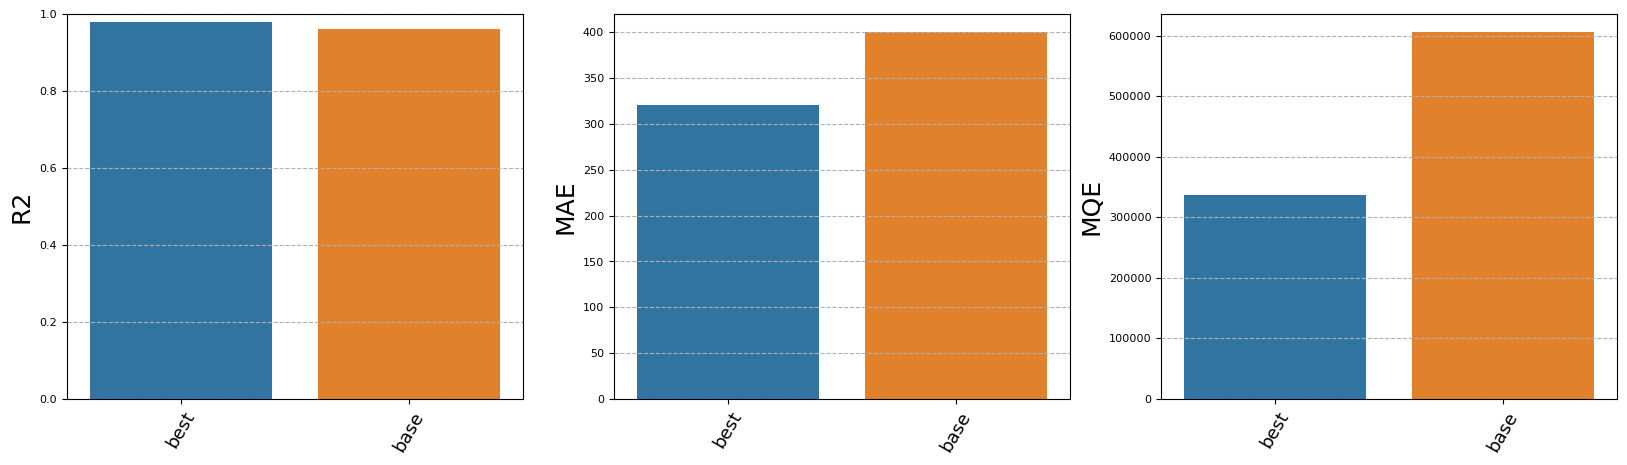

,pipeline,data,R2,mean_absolute_error,mean_square_error
1,best,test,0.979,321,336349
2,base,test,0.962,400,605963


In [44]:
regression_analysis(df_results)